In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools
import os
import random
from math import sqrt
from numpy.random import randn

# to plot some images
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.utils import shuffle


In [2]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
trainY = trainY.flatten()
testX = np.load('testX.npy')
testY = np.load('testY.npy')
testY = testY.flatten()

trainY = trainY.astype(int)
testY = testY.astype(int)

trainX, trainY = shuffle(trainX, trainY)
with open("testPaths.txt", "r") as f:
    testPaths = f.read().strip().split("\n")

with open("trainPaths.txt", "r") as f:
    trainPaths = f.read().strip().split("\n")
    

    
print(f"shape of trainX is : {trainX.shape}")
print(f"shape of trainY is : {trainY.shape}")
print(f"shape of testX is : {testX.shape}")
print(f"shape of testY is : {testY.shape}")
print(f"length of trainPaths is : {len(trainPaths)}")
print(f"length of testPaths is : {len(testPaths)}")

shape of trainX is : (18192, 4096)
shape of trainY is : (18192,)
shape of testX is : (4551, 4096)
shape of testY is : (4551,)
length of trainPaths is : 18192
length of testPaths is : 4551


In [3]:
class MLP(object):
    def __init__(self, num_inputs, num_hidden, num_outputs, weight_init):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.weight_init = weight_init
        
        self.layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
        
        self.activations = []
        self.weights = []
        self.biases = []
        self.d_weights = []
        self.d_biases = []
        
        # initialize random weights
        # create derivatives for weights
        # initialize random biases
        # create derivatives for biases
        
        for i in range(len(self.layers) - 1):
            
            if self.weight_init == "he":
                weights = np.random.randn(self.layers[i], self.layers[i + 1]) * np.sqrt(2./self.layers[i + 1])
                self.weights.append(weights)

                biases = np.zeros(self.layers[i + 1])
                self.biases.append(biases)

                self.d_weights.append(np.zeros((self.layers[i] , self.layers[i + 1])))
                self.d_biases.append(np.zeros(self.layers[i + 1]))  
            
            elif "random":
                weights =  0.01 *  np.random.rand(self.layers[i], self.layers[i + 1])
                self.weights.append(weights)

                self.d_weights.append(np.zeros((self.layers[i] , self.layers[i + 1])))

                biases = 0.01 * np.random.rand(self.layers[i + 1])
                self.biases.append(biases)

                self.d_biases.append(np.zeros(self.layers[i + 1]))            
            
        
        # create activations per layer
        for i in range(len(self.layers)):
            activation = np.zeros(self.layers[i])
            self.activations.append(activation)
            
        
    def forward(self, inputs):
        self.activations[0] = inputs
        activations = inputs

        for i, weights in enumerate(self.weights):
            z = np.dot(activations, weights) + self.biases[i]

            if i != len(self.weights) - 1:                
                activations = self.relu(z)
            else:
                activations = self.softmax(z)

            self.activations[i + 1] = activations

        return activations # output
        
        
    def train(self, inputs, labels, learningRate, epochs, test_inputs, test_labels):
        loss_history_training = []
        loss_history_test = []

        print("Starting to train.")
        print("-----------------")
        for i in range(epochs):
            sumError_train = 0
            sumError_test = 0
            for j,data in enumerate(inputs):
                label = labels[j]
                
                
                target = np.zeros(self.num_outputs)
                target[label] = 1

                output = self.forward(data)
                d_error = output - target
                    
                self.backpropagate(d_error)          

                self.gradient_descent(learningRate)
                
                sumError_train += self.categorical_cross_entropy_loss(target, output)
        
            for j,data in enumerate(test_inputs):
                test_label = test_labels[j]                

                test_target = np.zeros(self.num_outputs)
                test_target[test_label] = 1

                test_output = self.forward(data)

                sumError_test += self.categorical_cross_entropy_loss(test_target, test_output)
                
                                
            loss_history_training.append(sumError_train / len(inputs))
            loss_history_test.append(sumError_test / len(test_inputs))

            print(f"epoch: {i+1}/{epochs}, Loss: {sumError_train/len(inputs):.2f}, training accuracy: {self.evaluate(inputs, labels):.2f} ")
            
        
        return loss_history_training, loss_history_test

    def backpropagate(self, d_error):
        # dC / dZ = output(k) - target(k)  categorical cross entropy loss
        # dC/dW(l) = dC/dA * dA/dZ * dZ/dW(l-1)
        # dC/db(l) = dC/dA * dA/dZ * 1
        # dC/dW(l-1) = dC/dA * dA/dZ * dZ(l)/dA(l-1) * dA(l-1)/dZ(l-1) * dZ(l-1)/dW(l-1)
        for i in reversed(range(len(self.d_weights))):

            activations = self.activations[i + 1]
            
            if i == len(self.d_weights) - 1:
                commonDerivative = d_error
            else:
                commonDerivative = d_error * self.d_relu(activations)

            re_commonDerivative = commonDerivative.reshape(commonDerivative.shape[0], -1).T # 2d, 1 row

            # get activations for current layer
            current_activations = self.activations[i]
            # reshape activations as to have them as a 2d column matrix
            current_activations = current_activations.reshape(current_activations.shape[0],-1) #2d, 1 col

            self.d_weights[i] = np.dot(current_activations, re_commonDerivative)
            self.d_biases[i] = commonDerivative

            # backpropogate the error - the common part          
            d_error = np.dot(commonDerivative, self.weights[i].T)

    def gradient_descent(self, learningRate):
        for i in range(len(self.d_weights)):
            d_weights = self.d_weights[i]
            self.weights[i] = self.weights[i] - d_weights * learningRate

            d_biases = self.d_biases[i]
            self.biases[i] = self.biases[i] - d_biases * learningRate

    def relu(self, x):
        return x * (x > 0)

    def d_relu(self, x):
        return 1 * (x > 0)
    
    def tanh(self, x):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return t

    def d_tanh(self, x):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        dt=1-t**2
        return t
    def softmax(self, x):
        values = np.exp(x - np.amax(x))
        values = values / np.sum(values)
        values_clipped = np.clip(values, 1e-7, 1 - 1e-7)
        return values_clipped

    def categorical_cross_entropy_loss(self, targets, outputs):
        return -np.sum(targets * np.log(outputs))
    
    def predict(self, features):
        probabilities = self.forward(features)
        label = np.argmax(probabilities)
#         confidence = probabilities[0][label]
        confidence = probabilities[label]

        return label, confidence
    
    def evaluate(self, inputs, outputs):
        correct = 0
        classes = np.unique(outputs)
        conf_matrix = np.zeros((len(classes), len(classes)))
        
        for i, (data,label) in enumerate(zip(inputs,outputs)):
            prediction, _ = self.predict(data)
            if label == prediction:
                correct += 1
        
            conf_matrix[label][prediction] += 1 
            
        acc = correct / len(inputs)
        return acc       

In [4]:
# create a Multilayer Perceptron with one hidden layer
# model = MLP(4096, [64, 32], 10, "random")
model = MLP(4096, [128 ,64, 32], 10, "random")

# train network
before = time()
history_train, history_test = model.train(trainX, trainY, 0.001, 20, testX, testY)
print("-----------------")
print(f"time elapsed: {time()-before:.2f} seconds")

Starting to train.
-----------------
epoch: 1/20, Loss: 2.28, training accuracy: 0.14 
epoch: 2/20, Loss: 2.27, training accuracy: 0.14 
epoch: 3/20, Loss: 2.27, training accuracy: 0.14 
epoch: 4/20, Loss: 2.27, training accuracy: 0.14 
epoch: 5/20, Loss: 2.27, training accuracy: 0.14 
epoch: 6/20, Loss: 2.27, training accuracy: 0.14 
epoch: 7/20, Loss: 2.27, training accuracy: 0.14 
epoch: 8/20, Loss: 2.27, training accuracy: 0.14 
epoch: 9/20, Loss: 2.27, training accuracy: 0.14 
epoch: 10/20, Loss: 2.27, training accuracy: 0.14 
epoch: 11/20, Loss: 2.27, training accuracy: 0.14 
epoch: 12/20, Loss: 2.27, training accuracy: 0.14 
epoch: 13/20, Loss: 2.27, training accuracy: 0.14 
epoch: 14/20, Loss: 2.27, training accuracy: 0.14 
epoch: 15/20, Loss: 2.27, training accuracy: 0.14 
epoch: 16/20, Loss: 2.27, training accuracy: 0.14 
epoch: 17/20, Loss: 2.27, training accuracy: 0.14 
epoch: 18/20, Loss: 2.27, training accuracy: 0.14 
epoch: 19/20, Loss: 2.27, training accuracy: 0.14 
epo

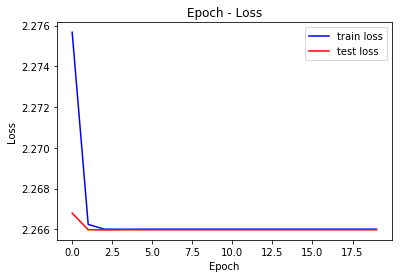

In [5]:
plt.plot(history_train, "-b", label="train loss")
plt.plot(history_test, "-r", label="test loss")
plt.title("Epoch - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [6]:
correct = 0
classes = np.unique(trainY)
conf_matrix = np.zeros((len(classes), len(classes)))
for i, (data,label) in enumerate(zip(testX,testY)):
    predict = np.argmax(model.forward(data))
    if label == predict:
        correct += 1
        
    conf_matrix[label][predict] += 1
    
acc = correct / len(testX)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.14
overall precision is nan
overall recall is 0.10


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [7]:
# create a Multilayer Perceptron with one hidden layer
# model = MLP(4096, [64, 32], 10, "he")
model = MLP(4096, [128 ,64, 32], 10, "he")

# train network
before = time()
history_train, history_test = model.train(trainX, trainY, 0.001, 20, testX, testY)
print("-----------------")
print(f"time elapsed: {time()-before:.2f} seconds")

Starting to train.
-----------------
epoch: 1/20, Loss: 1.92, training accuracy: 0.46 
epoch: 2/20, Loss: 1.31, training accuracy: 0.51 
epoch: 3/20, Loss: 0.87, training accuracy: 0.78 
epoch: 4/20, Loss: 0.58, training accuracy: 0.81 
epoch: 5/20, Loss: 0.43, training accuracy: 0.87 
epoch: 6/20, Loss: 0.35, training accuracy: 0.88 
epoch: 7/20, Loss: 0.30, training accuracy: 0.90 
epoch: 8/20, Loss: 0.25, training accuracy: 0.93 
epoch: 9/20, Loss: 0.19, training accuracy: 0.94 
epoch: 10/20, Loss: 0.16, training accuracy: 0.94 
epoch: 11/20, Loss: 0.13, training accuracy: 0.95 
epoch: 12/20, Loss: 0.11, training accuracy: 0.96 
epoch: 13/20, Loss: 0.10, training accuracy: 0.96 
epoch: 14/20, Loss: 0.09, training accuracy: 0.97 
epoch: 15/20, Loss: 0.08, training accuracy: 0.97 
epoch: 16/20, Loss: 0.07, training accuracy: 0.97 
epoch: 17/20, Loss: 0.07, training accuracy: 0.97 
epoch: 18/20, Loss: 0.06, training accuracy: 0.98 
epoch: 19/20, Loss: 0.05, training accuracy: 0.98 
epo

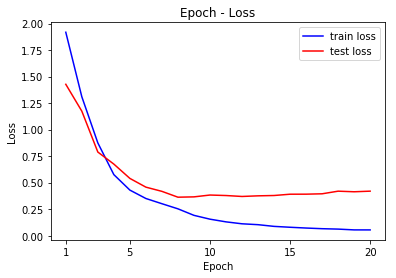

In [22]:
ticks = np.arange(20) + 1
plt.plot(ticks, history_train, "-b", label="train loss")
plt.plot(ticks, history_test, "-r", label="test loss")
plt.title("Epoch - Loss")
plt.xticks([1,5,10,15,20])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [9]:
correct = 0
classes = np.unique(trainY)
conf_matrix = np.zeros((len(classes), len(classes)))
for i, (data,label) in enumerate(zip(testX,testY)):
    predict = np.argmax(model.forward(data))
    if label == predict:
        correct += 1
        
    conf_matrix[label][predict] += 1

In [10]:
acc = correct / len(testX)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.93
overall precision is 0.93
overall recall is 0.93


In [11]:
# from scikitlearn 0.18 - old version
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

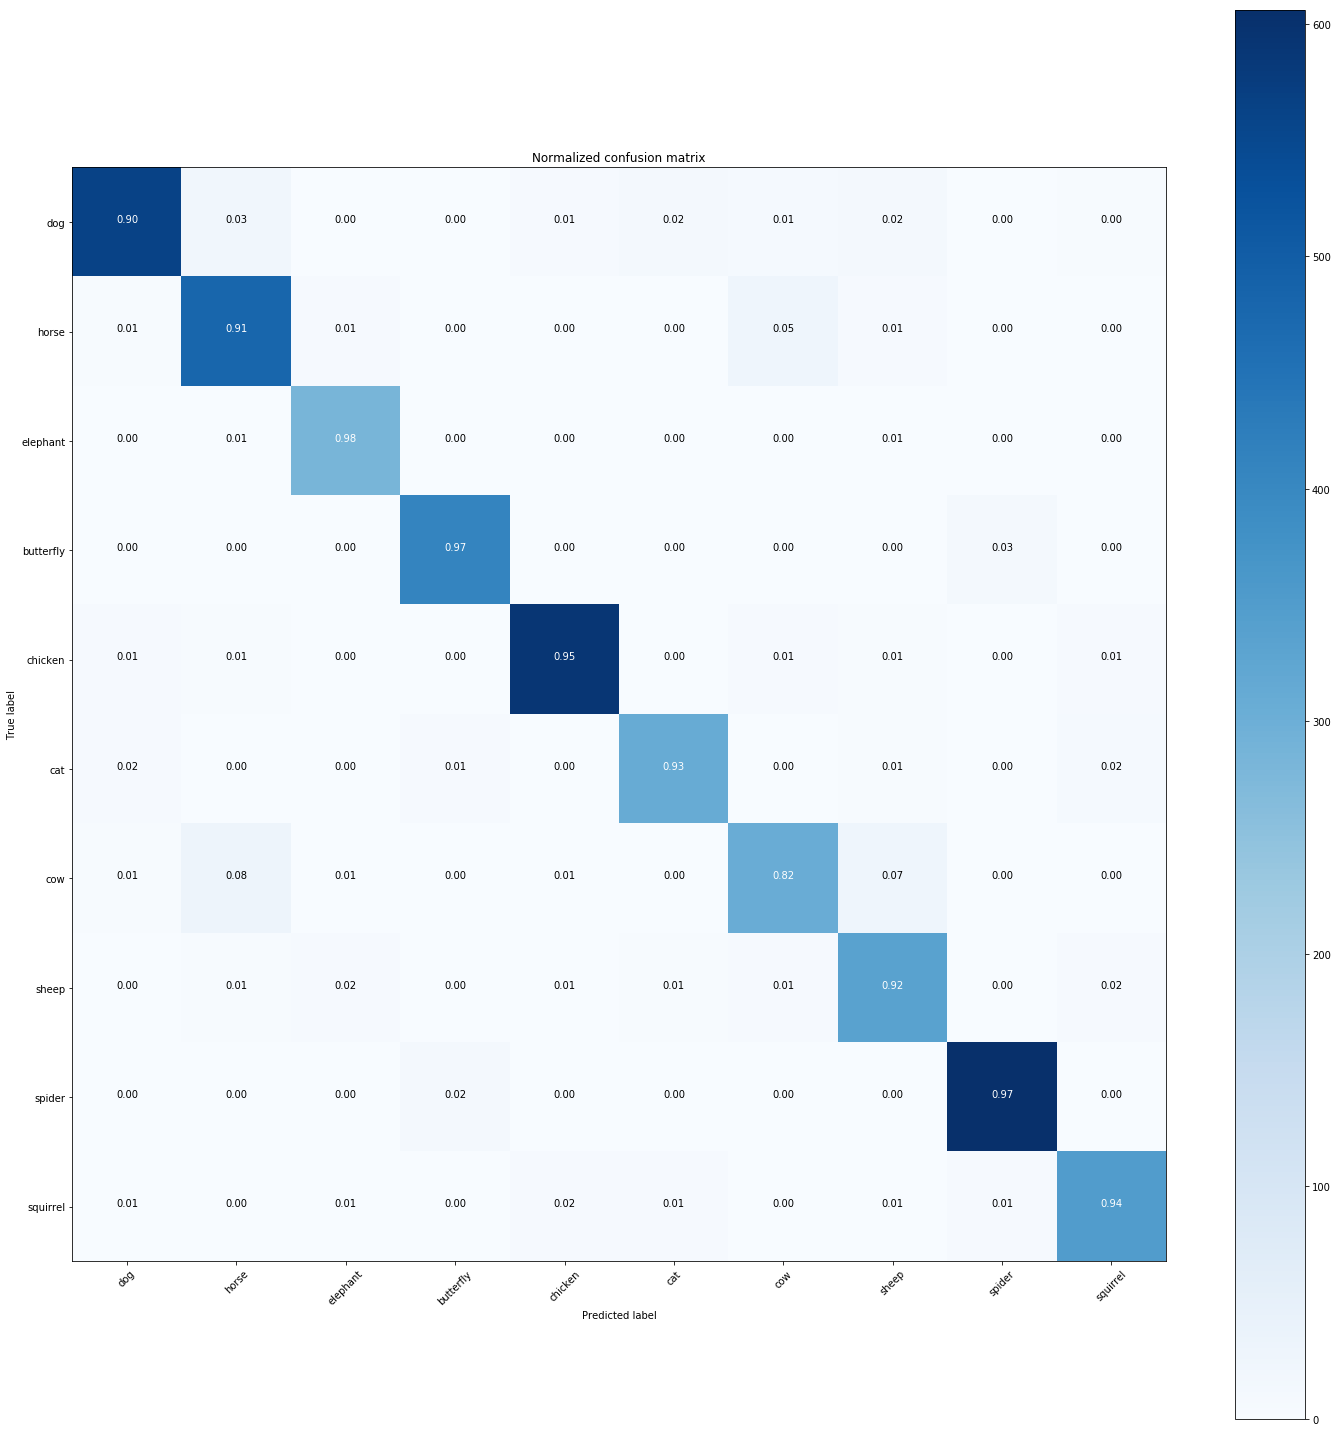

In [12]:
class_names = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider","squirrel"]

plt.figure()
plt.figure(figsize=(20,20))

plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [13]:
# to free up memory
del trainX
del trainY

In [14]:
vggModel = models.vgg16(pretrained=True)
vggModel.classifier = nn.Sequential(*list(vggModel.classifier.children())[:-3])
input_size = 224
mean = [0.5177, 0.5003, 0.4126]
std = [0.2135, 0.2130, 0.2151]
tensor_transform = transforms.Compose([
            transforms.Resize((input_size,input_size)),
            transforms.ToTensor()])

In [15]:
numberToClass = {
                 0: "dog",
                 1: "horse",
                 2: "elephant",
                 3: "butterfly",
                 4: "chicken",
                 5: "cat",
                 6: "cow",
                 7: "sheep",
                 8: "spider",
                 9: "squirrel"
}

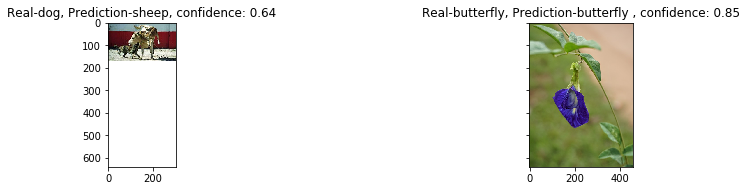

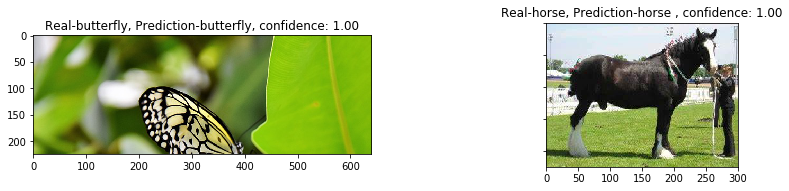

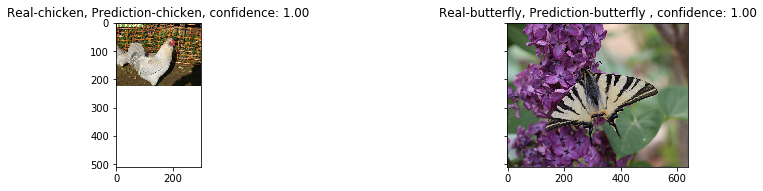

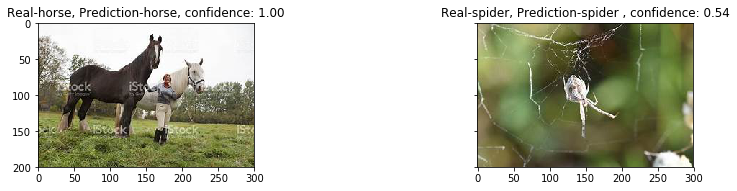

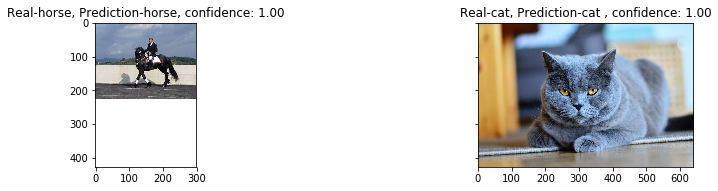

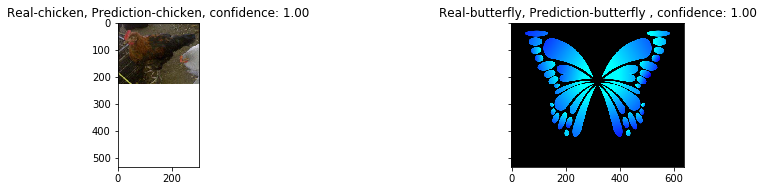

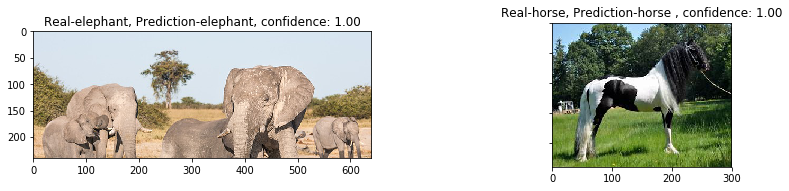

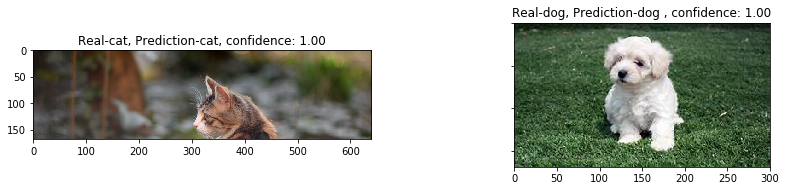

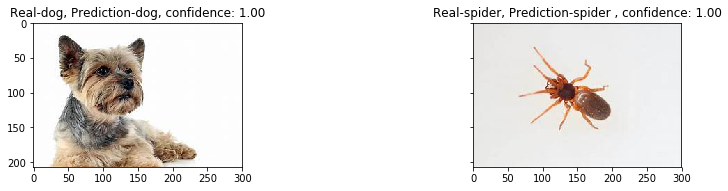

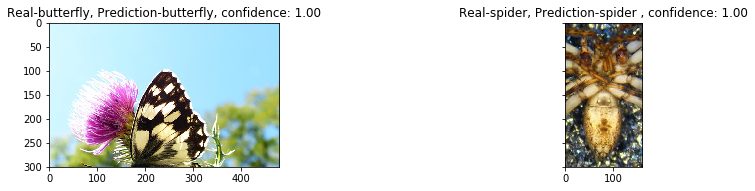

In [16]:
testNumber = 20
for i in range(int(testNumber/2)):
    randIndex1 = random.randint(0, len(testX) -1)
    randIndex2 = random.randint(0, len(testX) -1)

        
    im1 = Image.open(testPaths[randIndex1]).convert("RGB")
    im2 = Image.open(testPaths[randIndex2]).convert("RGB")

    
    features1 = testX[randIndex1]                                              
    features2 = testX[randIndex2]
                                              
    label1 = testY[randIndex1]
    label2 = testY[randIndex2]


    
    prediction1, confidence1 = model.predict(features1)
    prediction2, confidence2 = model.predict(features2)

    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plt.subplots_adjust(left=0.0, bottom=0, right=1.8, top=0.5,wspace=0.3, hspace=0.3)

    ax1.imshow(im1)
    ax2.imshow(im2)
    ax1.set_title(f"Real-{numberToClass[label1]}, Prediction-{numberToClass[prediction1]}, confidence: {confidence1:.2f}")
    ax2.set_title(f"Real-{numberToClass[label2]}, Prediction-{numberToClass[prediction2]} , confidence: {confidence2:.2f}")

    plt.show() 

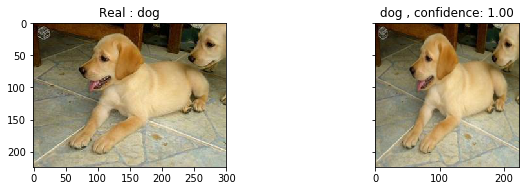

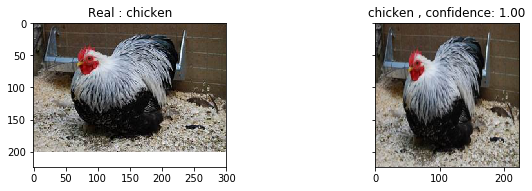

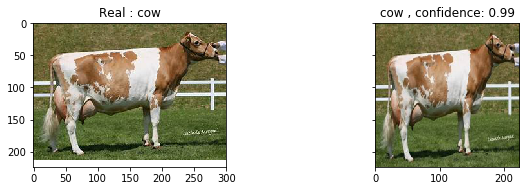

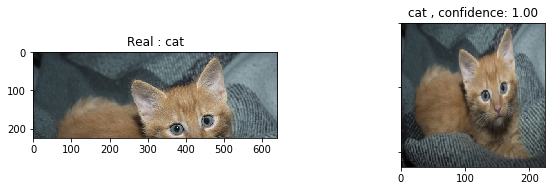

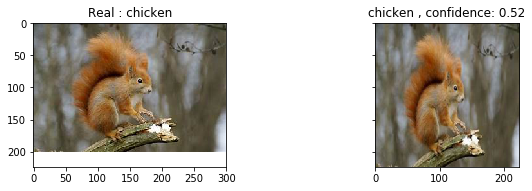

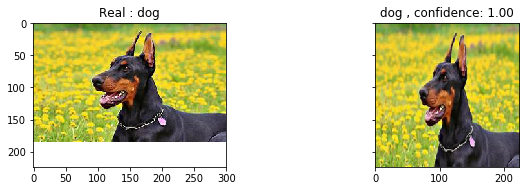

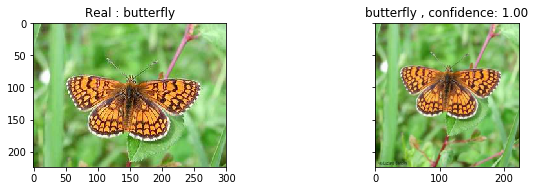

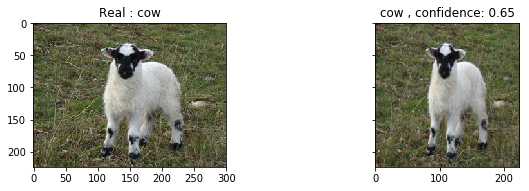

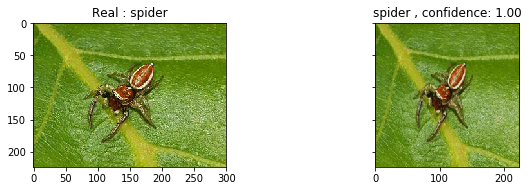

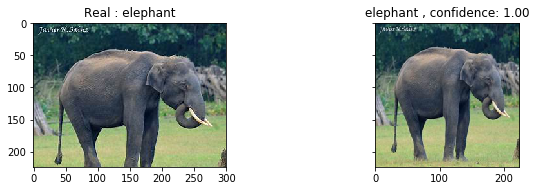

In [17]:
os.chdir("D:\\python\\animal classifier")


root_dir = os.getcwd()
testDir = os.path.join(root_dir, "plotImgs")
os.chdir(testDir)

file = open("labels.txt", "r")
labels = file.read().strip().split("-")

with torch.no_grad():
    for i in range(len(os.listdir())): # 1 file is txt file
        if f"{i+1}.jpg" in os.listdir():
            path = f"{i+1}.jpg"
                   
        elif f"{i+1}.jpeg" in os.listdir():
            path = f"{i+1}.jpeg"
                   
        else:
            continue

        imgPIL = Image.open(path) #PIL image
        imgTensor = tensor_transform(imgPIL) #torch.FloatTensor 3,224,224
        features = vggModel(imgTensor[None, ...])
        features = features.detach().numpy()  

        prediction, confidence = model.predict(features[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        plt.subplots_adjust(left=0.0, bottom=0, right=1.3, top=0.5,wspace=0.3, hspace=0.3)
        ax1.imshow(imgPIL)
        ax2.imshow( imgTensor.permute(1, 2, 0) )
        ax1.set_title(f"Real : {numberToClass[prediction]}")
        ax2.set_title(f"{numberToClass[prediction]} , confidence: {confidence:.2f}")

        plt.show() 